In [2]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, date, time, timedelta
from dateutil import parser
from dateutil import rrule

from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

%matplotlib inline
sns.set(style="white",context="talk")

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Goal
The goal of this challenge is to look at **user purchase history** and create categories of items that
are likely to be bought together and, therefore, should belong to the same section.
1. Find Customer ID: Find the customer who bought the most items overall in her lifetime
2. Find Customer ID: For each item, the customer who bought that product the most
3. Cluster items based on user co-purchase history. That is, create **clusters of products that
have the highest probability of being bought together**. The goal of this is to replace the
old/manually created categories with these new ones. Each item can belong to just one
cluster.

# 1. Load the Data and Answer the First Two Questions

In [12]:
# Load the dataset
purc = pd.read_csv("/content/drive/My Drive/Colab Notebooks/A collection of data challenge/9. Clustering Grocery Items/purchase_history.csv",sep = ",")
item = pd.read_csv("/content/drive/My Drive/Colab Notebooks/A collection of data challenge/9. Clustering Grocery Items/item_to_id.csv",sep = ",")

In [13]:
def view(df):
    # Exploring the data types, number of unique values and missing values
    cols = df.columns
    print(f"The dataset consists of {df.shape[0]} rows and {df.shape[1]} columns")
    print(f"The columns are: {df.columns.tolist()}")
    return pd.concat([pd.DataFrame({"data_types":df.dtypes, 
              "value_counts": df.nunique(),
             "null_counts": df.isnull().sum()}).T,df.iloc[0:3,:]],axis = 0)

For the purchase history dataset, there is no duplicates, and each row represents a user-purchase record. Therefore, the fact that there exists multiple user_id with different id concatenations means that user has purchased more than one times

In [14]:
purc.user_id = purc.user_id.astype(str)
view(purc)

The dataset consists of 39474 rows and 2 columns
The columns are: ['user_id', 'id']


,user_id,id
data_types,object,object
value_counts,24885,37309
null_counts,0,0
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"


In [15]:
item.Item_id = item.Item_id.astype(str)
view(item)

The dataset consists of 48 rows and 2 columns
The columns are: ['Item_name', 'Item_id']


,Item_name,Item_id
data_types,object,object
value_counts,48,48
null_counts,0,0
0,coffee,43
1,tea,23
2,juice,38


### Transform the purchase history dataset
split the comma in the id column, transform/stack the splitted columns back into one single column

In [17]:
temp = purc["id"].str.split(",",expand = True).stack().reset_index(level = 1,drop = True).rename("id")
purc = purc.drop("id",axis = 1).join(temp).reset_index().drop("index",axis = 1)
purc.columns = ["user_id","Item_id"]
view(purc)

The dataset consists of 319995 rows and 2 columns
The columns are: ['user_id', 'Item_id']


,user_id,Item_id
data_types,object,object
value_counts,24885,48
null_counts,0,0
0,222087,27
1,222087,26
2,1343649,6


In [24]:
purc.head(10)

,user_id,Item_id
0,222087,27
1,222087,26
2,1343649,6
3,1343649,47
4,1343649,17
5,404134,18
6,404134,12
7,404134,23
8,404134,22
9,404134,27


## Question 1: Find the customer who bought the most items overall in her lifetime

In [18]:
customer_list1 = pd.DataFrame(purc.groupby("user_id").Item_id.count().sort_values(ascending = False).reset_index())
customer_list1.columns=["user_id","num_items_purchase"]
customer_list1.head()

,user_id,num_items_purchase
0,269335,72
1,367872,70
2,397623,64
3,599172,64
4,377284,63


## Question 2: For each item, the customer who bought that product the most

In [19]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
q = """
    SELECT p.user_id,p.Item_id,i.Item_name
    FROM purc p INNER JOIN item i ON p.Item_id = i.Item_id
   """
purc_item = pysqldf(q)
purc_item["num_purchases"] = 1
purc_item = purc_item.reset_index().drop("index",axis =1).groupby(by=["Item_id","Item_name","user_id"]).count().sort_values(by = "num_purchases",ascending = False).reset_index()

In [20]:
q = """
    SELECT Item_id, Item_name, user_id, num_purchases
    FROM purc_item
    WHERE (Item_id, Item_name, user_id, num_purchases) IN (SELECT Item_id, Item_name, user_id, MAX(num_purchases) FROM purc_item GROUP BY Item_id, Item_name)
   """
customer_list2 = pysqldf(q)
customer_list2

,Item_id,Item_name,user_id,num_purchases
0,23,tea,920002,5
1,18,laundry detergent,917199,5
2,39,sandwich loaves,599172,5
3,45,cauliflower,1198106,5
4,2,lettuce,269335,5
5,9,soda,269335,4
6,20,grapefruit,1100981,4
7,25,cherries,68282,4
8,42,cucumbers,80215,4
9,34,tortillas,557099,4


# 2. Question 3 - Clustering

For each user purchase, exhaustively list out all their combinations of items, and calculate their frequencies across all users' purchase histories.

or
supervised learning - y = is bought together or not, x is 48 dummies

or
**K-Means：**
If two data points are close to each other, then it means they appear similarly among all the purchase orders, which means customers tend to purchase/not purchase them together. So we bundle them together accordingly.

### 2-1. Data preparation
The desired structure is number of items as rows and number of purchase records as columns. Therefore, the distance features reflects **how the two items are bundled across all orders** (Either they are purchased together or not purchased together)

In [21]:
purc_cluster = pd.read_csv("/content/drive/My Drive/Colab Notebooks/A collection of data challenge/9. Clustering Grocery Items/purchase_history.csv",sep = ",")

In [22]:
purc_cluster = purc_cluster.drop("user_id",axis = 1)
purc_cluster["purc_id"] = [i+1 for i in range(len(purc_cluster))]

In [ ]:
def split_item_id(df):
    """
    This function splits the id column in the purchase history dataframe,
    and adds 48 columns representing the 48 items in the store.
    If the user purchases a specific item, then I mark as 1 in that record

    Input:
       df (dataframe with 2 columns: purc_id, id)
    Output:
       df (dataframe with 49 columns: purc_id + 48 dummy ids)
    """
    df["id"] = list(map(lambda x:x.split(","),df["id"]))
    for i in range(1,49):
        df[str(i)] = 0
    print("48 dummy columns successfully created!")
    for m in range(len(df)):
        for n in df.id.iloc[m]:
            df.loc[m,str(n)] = 1
        if m == 10000:
            print("10000th row transformed.")
        elif m == 20000:
            print("20000th row transformed")
        elif m == 30000:
            print("30000th row transformed")
    return df

In [ ]:
purc_cluster = split_item_id(purc_cluster)

48 dummy columns successfully created!
10000th row transformed.
20000th row transformed
30000th row transformed


,id,purc_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
0,"[27, 26]",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"[6, 47, 17]",2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,"[18, 12, 23, 22, 27, 43, 38, 20, 35, 1]",3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0


In [ ]:
temp = purc_cluster.drop(["id"],axis = 1).set_index("purc_id")
data = temp.T
data.head()

purc_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,39435,39436,39437,39438,39439,39440,39441,39442,39443,39444,39445,39446,39447,39448,39449,39450,39451,39452,39453,39454,39455,39456,39457,39458,39459,39460,39461,39462,39463,39464,39465,39466,39467,39468,39469,39470,39471,39472,39473,39474
1,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0
2,0,0,0,1,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,...,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 2-2. Applying PCA 
Shrink the 39000+ purchases-record dimensions

In [ ]:
# PCA for dimension reduction
pca = PCA(n_components=2, random_state=42)
pca = pca.fit(data)
pca_output = pca.transform(data)

# standardize the results
from sklearn.preprocessing import StandardScaler
pca_data = pd.DataFrame(StandardScaler().fit_transform(pca_output))
pca_data.head()

,0,1
0,0.660206,-0.091033
1,3.733556,-1.734963
2,0.123848,-0.208948
3,-1.017929,-0.179658
4,-1.177004,-0.163107


In [ ]:
# A quick glance
sns.scatterplot(pca_data[0],pca_data[1],marker = "o")
plt.xlabel("PCA_Component_1",fontsize = 16)
plt.ylabel("PCA_Component_2",fontsize = 16)
plt.grid("--",alpha = 0.5)

### 2-3. Buidling K-Means
Selecting the optimal K and visualizing the results

I am using two evaluation criteria here: sum of squared distance (Elbow) and the Silhouette coefficient.   
Reference: https://blog.csdn.net/Santorinisu/article/details/104459514

**within-cluster (SSE) distortion** - to compare the performance of different k-means clusterings:
Intuitively, if k increases, the distortion will **decrease**. This is because the samples will be closer to the centroids they are assigned to. The idea behind the elbow method is to identify the value of k where the **distortion begins to increase most rapidly**

**Silhouette score:** = (separation score-cohesion score)/max(separation score, cohesion score)
Silhouette score is bounded in the range of -1 to 1. The closest to 1, separation score is the largest, which indicates that an ideal silhouette coefficient is obtained, since separation score quantifies how dissimilar a sample is to other clusters and cohesion score tells how similar it is to the other samples in its own cluster.

In [ ]:
# determine the best number of clusters
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.cluster import KMeans
clusters = range(2, 20)
inertias = []
silhouettes = []

for n_clusters in clusters:
  # Set n_init=10 to run k-means clustering algorithm 10 times independently
  # with different centroids to choose the final model with the lowest SSE
    kmeans = KMeans(n_clusters = n_clusters, init='k-means++', n_init = 10, max_iter=300,random_state=123, n_jobs=-1)
    kmeans = kmeans.fit(pca_data)
    label = kmeans.predict(pca_data)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(pca_data, label))

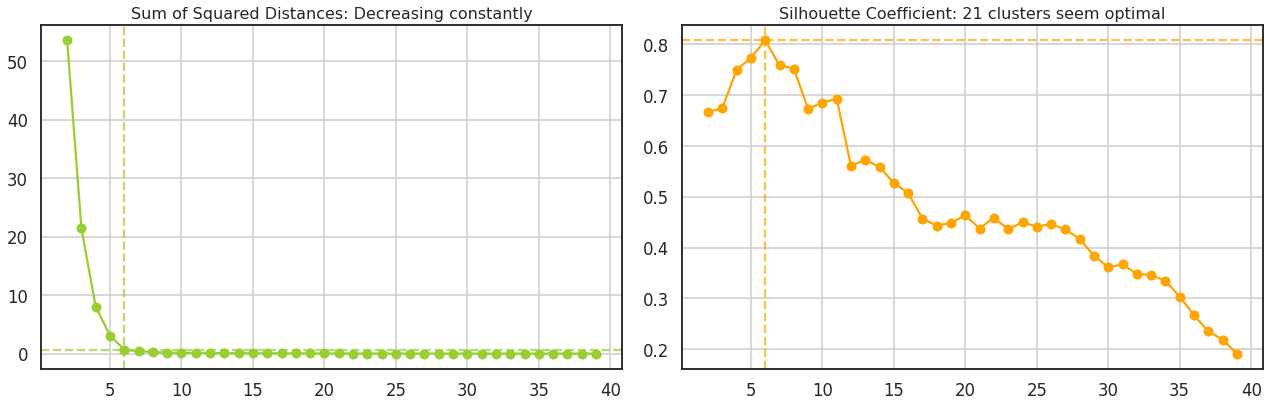

In [ ]:
# visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax[0].plot(clusters, inertias, 'o-',color = "yellowgreen")
ax[0].set_title("Sum of Squared Distances: Decreasing constantly",fontsize = 16)
ax[0].axhline(y=inertias[4],ls="--",c="yellowgreen",alpha = 0.7)
ax[0].axvline(x=6,ls="--",c="yellowgreen",alpha = 0.7)
ax[0].grid(True)

ax[1].plot(clusters, silhouettes, 'o-',color = "orange")
ax[1].grid(True)
ax[1].axhline(y=silhouettes[4],ls="--",c="orange",alpha = 0.7)
ax[1].axvline(x=6,ls="--",c="orange",alpha = 0.7)
ax[1].set_title("Silhouette Coefficient: 6 clusters seem optimal",fontsize = 16)
plt.tight_layout()
plt.show()

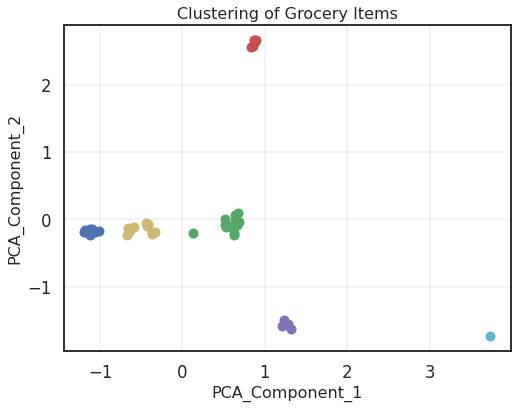

In [ ]:
best_km = KMeans(n_clusters=6,  init='k-means++', n_init = 10, max_iter=300,random_state=123, n_jobs=-1).fit(pca_data)
best_label = best_km.predict(pca_data)

# visualization in 2D
colors = ['b', 'g', 'r', 'c', 'm', 'y']

fig, ax = plt.subplots(figsize=(8, 6))
for j in range(len(pca_data)):
    x = pca_data.iloc[j,0]
    y = pca_data.iloc[j,1]
    ax.plot(x, y, 'o', color=colors[best_label[j] % 6])
    name = item[item['Item_id'] == str(j + 1)]['Item_name']
    #ax.annotate(xy=(x+0.2, y+0.2), s=name.values[0], fontsize=12)

plt.title("Clustering of Grocery Items",fontsize = 16)
plt.xlabel("PCA_Component_1",fontsize = 16)
plt.ylabel("PCA_Component_2",fontsize = 16)
plt.grid("--",alpha=.3)
plt.show()

## 2-4. Result

In [ ]:
pd.set_option('max_colwidth',100)
item.Item_id = item.Item_id.astype(int)
item["cluster_id"] = best_label+1
pd.DataFrame(item.groupby('cluster_id')['Item_name'].apply(lambda x:x.str.cat(sep=', ')))


,Item_name
cluster_id,
1,"soda, sandwich loaves, tortillas, ketchup, cheeses, yogurt, sugar,..."
2,"coffee, juice, dinner rolls, canned vegetables, eggs, cereals, ice..."
3,"pasta, beef, broccoli, toilet paper, shaving cream"
4,tea
5,"spaghetti sauce, sandwich bags, soap, hand soap"
6,"bagels, milk, butter, flour, waffles, frozen vegetables, pork, ban..."
